# Store sales forecasting

**Indian Restaurant datatset**: https://www.kaggle.com/henslersoftware/19560-indian-takeaway-orders

Predict the number of daily orders for future
using pandasql(working with SQL) and XGBoost

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

In [13]:
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

In [42]:
orders = pd.read_csv("C:\\PROJECT\\restaurant-1-orders.csv\\restaurant-1-orders.csv")
orders.columns = ['number', 'timestamp', 'item', 'quantity', 'price', 'total_products_in_cart']


In [43]:
orders.sample(2)

,number,timestamp,item,quantity,price,total_products_in_cart
12679,11520,10/10/2018 20:15,Plain Naan,1,2.60,4
57082,12360,07/12/2018 19:14,Dhansak - Chicken,1,8.95,5


In [44]:
orders['date'] = pd.to_datetime(orders['timestamp'].str[:10])

In [45]:
orders.sample(2)

,number,timestamp,item,quantity,price,total_products_in_cart,date
19443,12204,25/11/2018 20:24,Pilau Rice,2,2.95,4,2018-11-25
57408,11971,10/11/2018 18:37,Korma - Chicken,1,8.95,14,2018-10-11


In [46]:
print(f"Total number of orders in dataset: {orders['number'].nunique()}")

Total number of orders in dataset: 13397


### Direct Multistep Forecasting 

In [47]:

daily_orders = pysqldf('''WITH Distinct_orders AS (
        SELECT DISTINCT
            number,
            DATE(date) AS date
        FROM orders
        )

        SELECT 
            date,
            COUNT(*) AS num_orders 
        FROM distinct_orders
        GROUP BY 1
        ORDER BY 1''')

In [48]:
daily_orders.sample(2)

,date,num_orders
263,2016-12-23,17
682,2018-02-19,5


In [27]:
import logging
logging.getLogger().setLevel(logging.CRITICAL) # Prevent the matplotlib infos on categorical x-axis, removable

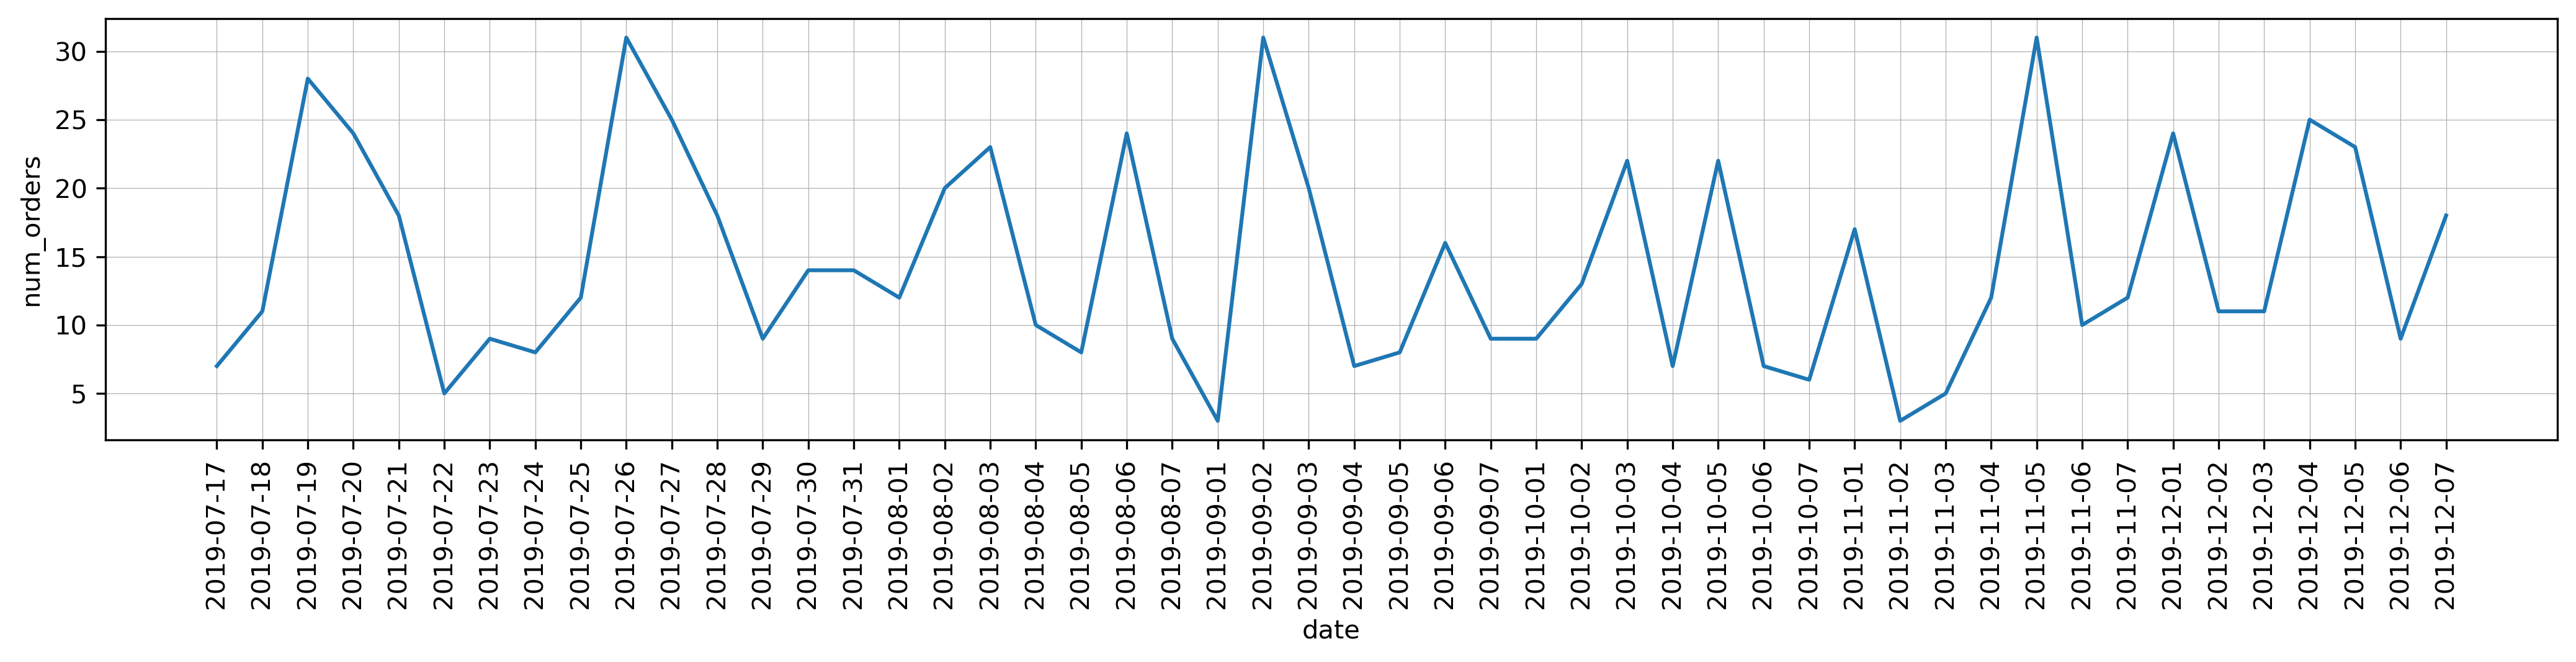

In [28]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=daily_orders.tail(50), x='date', y='num_orders')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

Too less orders daily to bother forecasting. Let's look at weekly order volume instead

In [71]:
weekly_orders = pysqldf('''
        SELECT 
            DATE(date, '-7 DAYS', 'WEEKDAY 1') AS week,
            COUNT(*) AS num_orders 
        FROM (
            SELECT DISTINCT
                number,
                DATE(date) AS date
            FROM orders
        )
        GROUP BY 1
        ORDER BY 1''')

In [72]:
weekly_orders.sample(2)

,week,num_orders
51,2016-12-19,53
151,2018-11-19,88


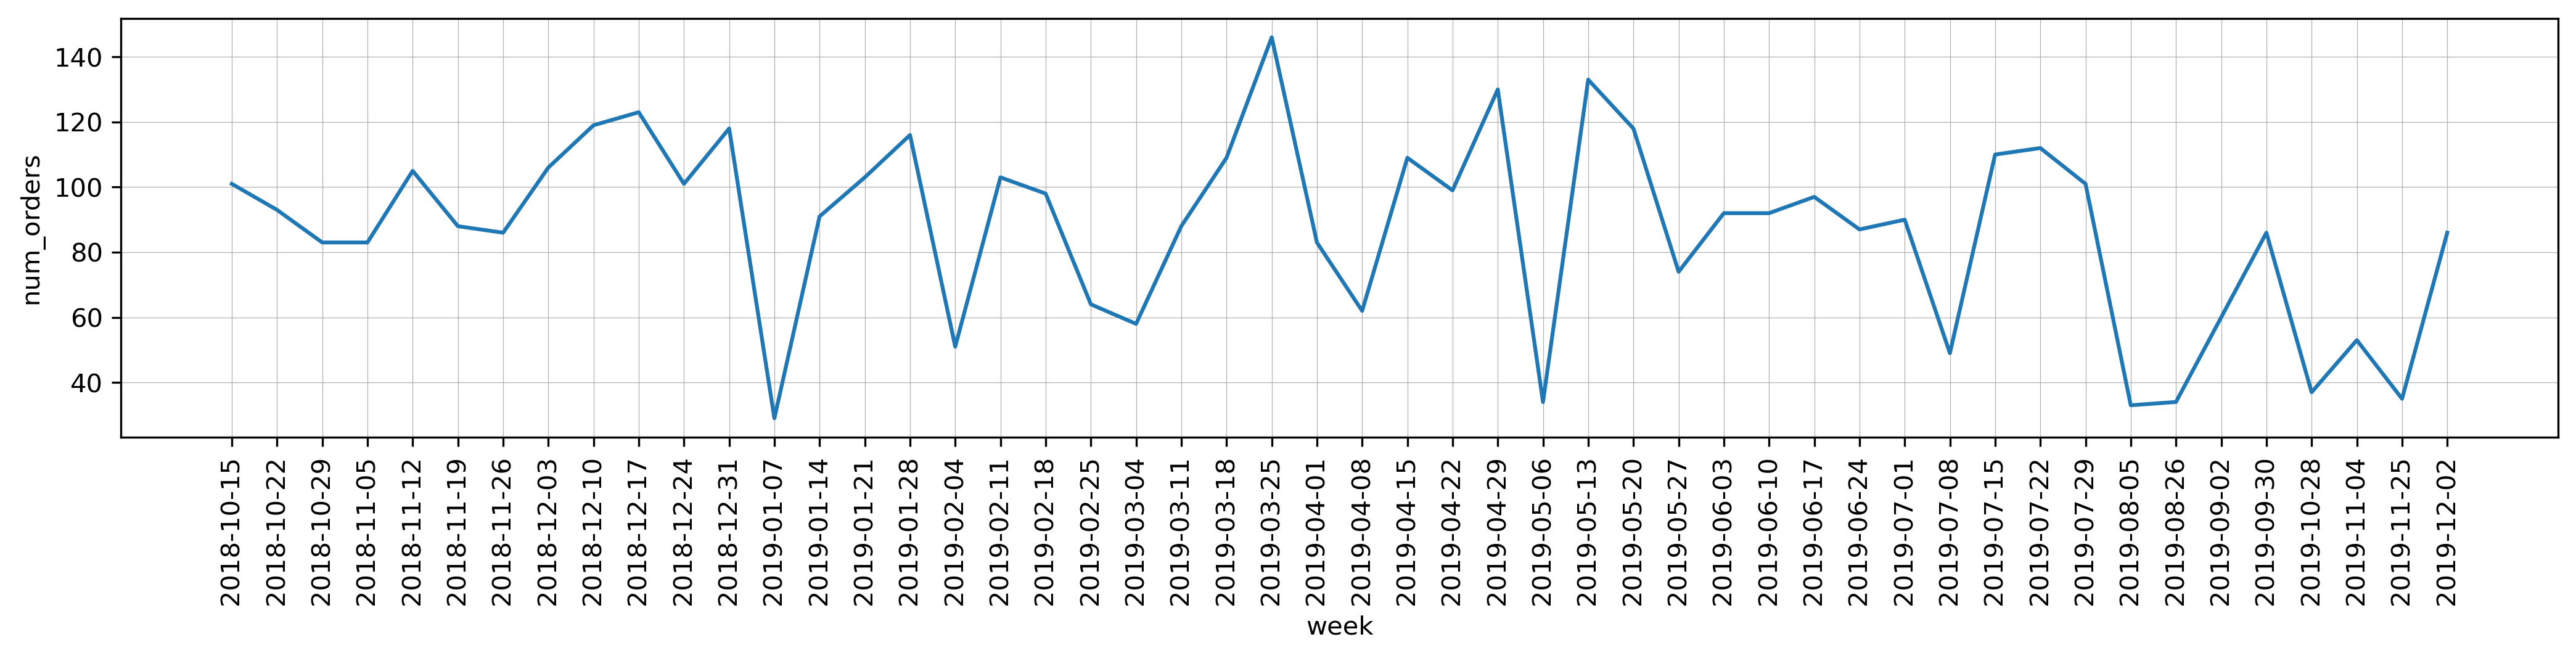

In [73]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=weekly_orders.tail(50), x='week', y='num_orders')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

In [78]:
df = pysqldf('''WITH distinct_orders AS (
            SELECT DISTINCT
                number,
                DATE(date) AS date
            FROM orders
        ),

        weekly_orders AS (
            SELECT 
                DATE(date, '-7 DAYS', 'WEEKDAY 1') AS week,
                COUNT(*) AS num_orders 
            FROM distinct_orders
            GROUP BY 1
        ),

        recent_7_day_orders AS (
            SELECT 
                orders.week,
                COUNT(recent_orders.number) AS order_count
            FROM weekly_orders orders
            JOIN distinct_orders recent_orders
                ON recent_orders.date < orders.week
                AND recent_orders.date >= DATE(orders.week, '-7 DAYS') 
            GROUP BY 1
        ),

        recent_30_day_orders AS (
            SELECT 
                orders.week,
                COUNT(recent_orders.number) AS order_count
            FROM weekly_orders orders
            JOIN distinct_orders recent_orders
                ON recent_orders.date < orders.week
                AND recent_orders.date >= DATE(orders.week, '-30 DAYS') 
            GROUP BY 1
        ),

        labels AS (
            SELECT 
                orders.week,
                COUNT(label_orders.number) AS order_count
            FROM weekly_orders orders
            JOIN distinct_orders label_orders
                ON label_orders.date >= orders.week
                AND label_orders.date < DATE(orders.week, '7 DAYS') 
            GROUP BY 1
        )

        SELECT
            orders.week,
            COALESCE(recent_7_day_orders.order_count, 0) AS order_count_7_day,
            COALESCE(recent_30_day_orders.order_count, 0) AS order_count_30_day,
            COALESCE(labels.order_count, 0) AS next_week_count
        FROM weekly_orders orders
        LEFT JOIN recent_7_day_orders
            ON recent_7_day_orders.week = orders.week
        LEFT JOIN recent_30_day_orders
            ON recent_30_day_orders.week = orders.week
        LEFT JOIN labels
            ON labels.week = orders.week
        WHERE orders.week >= '2016-01-01' ''')

In [79]:
df.sample(3)

,week,order_count_7_day,order_count_30_day,next_week_count
154,2019-01-21,93,404,99
16,2016-05-23,31,154,50
68,2017-05-29,62,266,57


In [81]:
features = ['order_count_7_day', 'order_count_30_day']
next_week_count = 'next_week_count'
test_df = df[df['week'] >= '2019-06-01']
train_df = df[df['week'] < '2019-06-01']
X_train, y_train = train_df[features], train_df[next_week_count]
X_test, y_test = test_df[features], test_df[next_week_count]

In [82]:
reg = XGBRegressor(n_estimators=500, learning_rate=0.01)
reg.fit(X_train, 
        y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric='mae')

[0]	validation_0-mae:68.79896	validation_1-mae:72.73835
[1]	validation_0-mae:68.12780	validation_1-mae:72.12849
[2]	validation_0-mae:67.46320	validation_1-mae:71.52455
[3]	validation_0-mae:66.80495	validation_1-mae:70.89914
[4]	validation_0-mae:66.15327	validation_1-mae:70.30690
[5]	validation_0-mae:65.50796	validation_1-mae:69.72042
[6]	validation_0-mae:64.86883	validation_1-mae:69.11306
[7]	validation_0-mae:64.23606	validation_1-mae:68.53793
[8]	validation_0-mae:63.60948	validation_1-mae:67.96839
[9]	validation_0-mae:62.98889	validation_1-mae:67.37857
[10]	validation_0-mae:62.37450	validation_1-mae:66.82005
[11]	validation_0-mae:61.76610	validation_1-mae:66.26696
[12]	validation_0-mae:61.16365	validation_1-mae:65.71924
[13]	validation_0-mae:60.56696	validation_1-mae:65.16514
[14]	validation_0-mae:59.97622	validation_1-mae:64.62995
[15]	validation_0-mae:59.39126	validation_1-mae:64.09996
[16]	validation_0-mae:58.81189	validation_1-mae:63.60182
[17]	validation_0-mae:58.23830	validation

C:\Users\nalin\anaconda3\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[38]	validation_0-mae:47.42650	validation_1-mae:53.57262
[39]	validation_0-mae:46.96579	validation_1-mae:53.16629
[40]	validation_0-mae:46.50969	validation_1-mae:52.75676
[41]	validation_0-mae:46.05802	validation_1-mae:52.35745
[42]	validation_0-mae:45.60923	validation_1-mae:51.94620
[43]	validation_0-mae:45.17337	validation_1-mae:51.54773
[44]	validation_0-mae:44.74149	validation_1-mae:51.15996
[45]	validation_0-mae:44.31487	validation_1-mae:50.76914
[46]	validation_0-mae:43.89044	validation_1-mae:50.38212
[47]	validation_0-mae:43.46798	validation_1-mae:49.99716
[48]	validation_0-mae:43.05840	validation_1-mae:49.63234
[49]	validation_0-mae:42.65503	validation_1-mae:49.25643
[50]	validation_0-mae:42.25111	validation_1-mae:48.87605
[51]	validation_0-mae:41.85718	validation_1-mae:48.52061
[52]	validation_0-mae:41.46394	validation_1-mae:48.15511
[53]	validation_0-mae:41.07018	validation_1-mae:47.79993
[54]	validation_0-mae:40.68760	validation_1-mae:47.45458
[55]	validation_0-mae:40.30873	

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [83]:
predictions = reg.predict(X_test)

In [84]:
test_df = test_df.reset_index().drop('index', axis=1)
test_df['predictions'] = pd.Series(predictions)

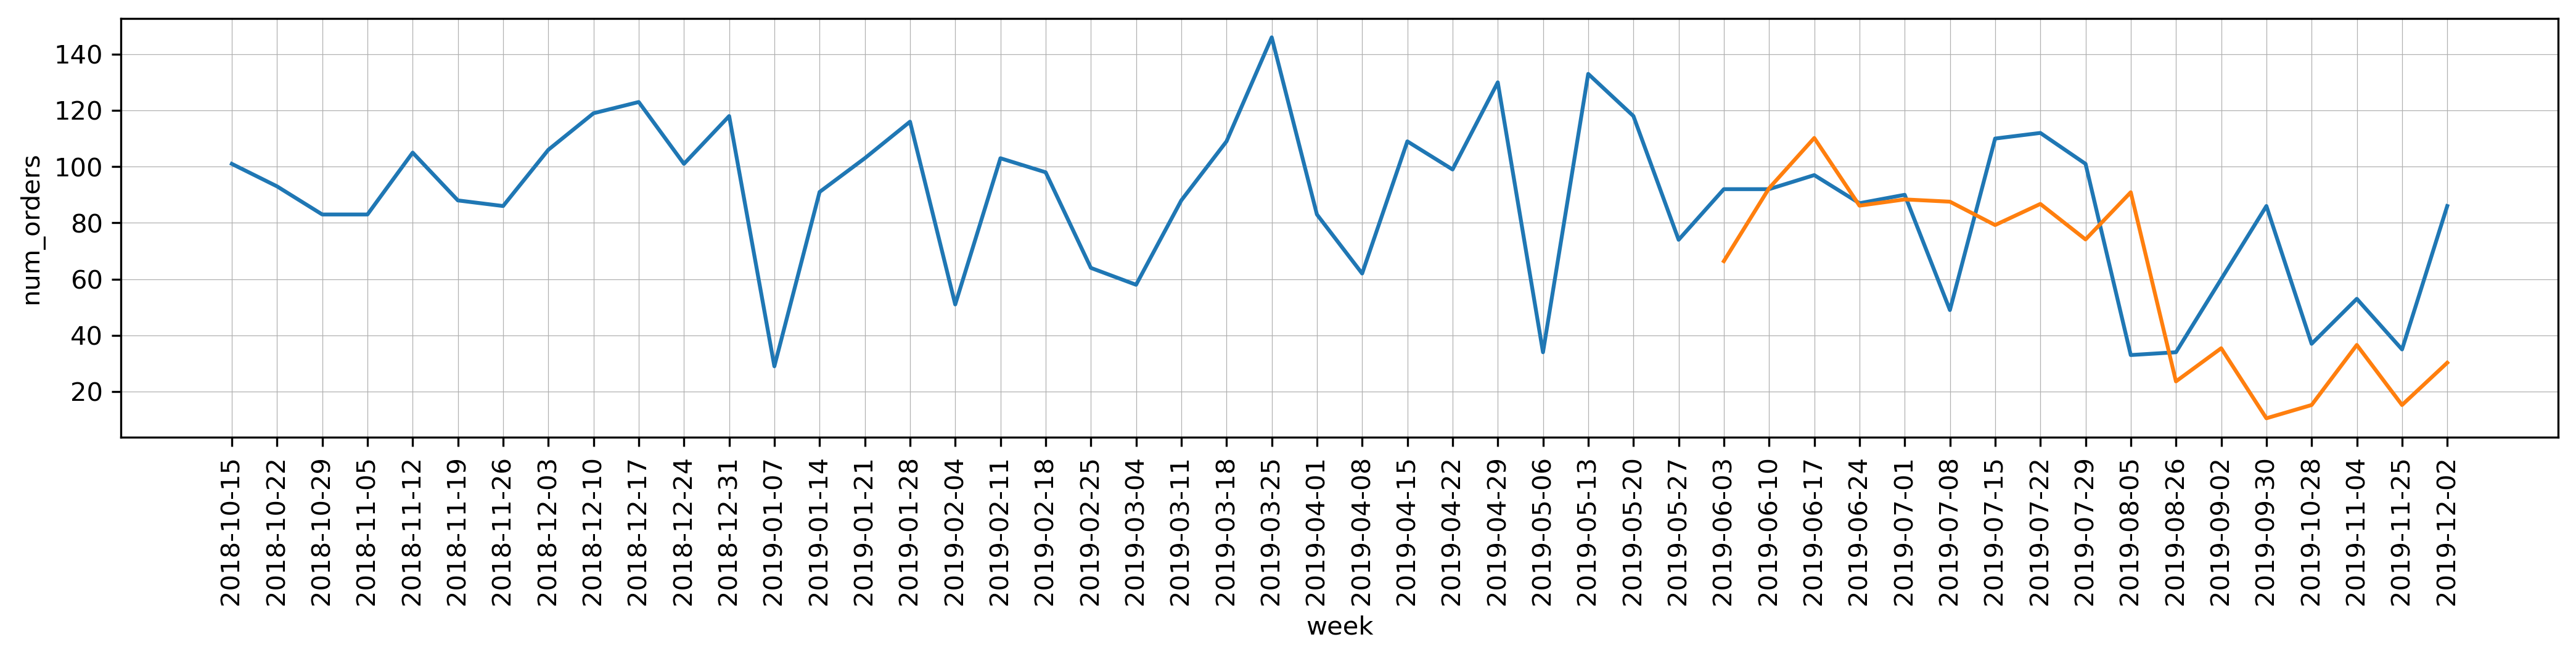

In [85]:
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=weekly_orders.tail(50), x='week', y='num_orders')
sns.lineplot(data=test_df, x='week', y='predictions')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

In [86]:
test_df

,week,order_count_7_day,order_count_30_day,next_week_count,predictions
0,2019-06-03,84,416,100,66.390121
1,2019-06-10,100,428,76,92.323196
2,2019-06-17,76,433,102,110.203674
3,2019-06-24,102,414,94,86.136444
4,2019-07-01,94,389,94,88.356865
5,2019-07-08,94,366,40,87.550446
6,2019-07-15,40,377,114,79.235611
7,2019-07-22,114,381,108,86.746536
8,2019-07-29,108,393,102,74.123482
9,2019-08-05,102,406,41,90.902100


The model predicts with a mean absolute error of 30.13.